Corentin PRADIE
Lucas TAVANI
Mehdi REMILI
Romain VILLENEUVE
L3C

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

## Fonctions créé pour l'evalutaion des modèles (voir print_test_results.py) :

# Recupère et Affiche le meilleur modèle trouvé par GridSearch
from print_test_results import get_test_results, print_test_results
# Plot les predictions face aux valeurs attendues
from print_test_results import plot_scatter_predictions
# Affiche l'importance (coef_ ou feature_importances_) du meilleur modèle
from print_test_results import plot_top_coefficients_or_importances
# Compare les resultats des meilleurs modèles FR et DE 
from print_test_results import get_comparison_table
from IPython.display import Markdown

# RandomForestRegressor

Nous utlisons la classe `RandomizedSearchCV` pour trouver la combinaison de *Transformers* et d'hyperparametres donnant les meilleurs resultats. 

`RandomizedSearchCV` est une méthode de sélection d'hyperparamètres pour un modèle d'apprentissage automatique qui, contrairement à GridSearchCV, explore un ensemble de paramètres de manière aléatoire. Plutôt que de tester toutes les combinaisons possibles de paramètres, RandomizedSearchCV sélectionne un nombre défini de combinaisons de paramètres au hasard dans une distribution spécifiée. Cette approche peut être plus efficace en termes de temps de calcul et peut être utilisée pour une recherche plus large et plus rapide de combinaisons de paramètres.

Nous allons utiliser la classe `Pipeline` pour eviter la fuite de données de l'ensemble de test sur l'entrainement des modèles.
De plus `Pipeline` nous permet de faire varier les hyperparametres mais aussi les transformers lors de la recherche exhaustive effectuée par GridSearch.

In [2]:
pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', None),
    ('model', RandomForestRegressor(n_jobs=-1))
])

Nous definissions maintennat les parametres a faire varier:
- Trois façons de traiter les valeurs manquantes : les retirer ('constant' + fill_value = 'None'), ou les remplacer par le médiane ou la moyenne

```python
'imputer__strategy': ['constant', 'mean', 'median'],
'imputer__fill_value': [None],
```

- 2 mises a echelles : Standardisation, et une normalisation robuste face aux valeurs aberrantes (RobustScaler : soustraction par la médiane et divison par l'IQR)

```python
'scaler' : [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
```

- Differentes profondeurs de l'arbre:
```python
'model__max_depth': range(3, 21)
```
- Le nombre minimum d'échantillons requis pour diviser un nœud interne de l'arbre:
```python
'model__min_samples_split': range(2, 11),
```
- Le nombre minimum d'échantillons requis pour former une feuille de l'arbre:
```python
'model__min_samples_leaf': range(1, 11)
```


In [3]:
param_grid = {
    'imputer__strategy': ['constant', 'mean', 'median'],
    'imputer__fill_value': [None],
    'scaler' : [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
    'model__n_estimators': [100],
    'model__max_depth': range(3, 10),
    'model__min_samples_split': range(2, 11),
    'model__min_samples_leaf': range(1, 11)
}



`RandomizedSearchCV` testera 100 combinaisons de hyper-parametres et *transformers*:

In [4]:
n_iter = 100

Nous evaluerons les modèles trouvés par `RandomizedSearchCV` avec la coefficient de determination R2:

In [5]:
scoring = {
    'r2' : 'r2',
}

Les modèles seront evalué avec une 5 validation croisée

In [6]:
refit = 'r2'
cv = 5

In [7]:
test_results = {
    'fr':{},
    'de':{}
}

## France

In [8]:
data_fr = pd.read_csv('data/Data_FR.csv', index_col='ID')
data_fr.shape

(680, 34)

In [9]:
X = data_fr.drop('TARGET', axis=1)
y = data_fr['TARGET']
title = 'RandomForestRegressor FR' 

In [10]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rand_search = RandomizedSearchCV(pipeline, param_grid, scoring=scoring,n_iter=n_iter, cv=cv, refit=refit, n_jobs=-1, verbose=1, random_state=42)
rand_search.fit(X_train, y_train)

y_pred = rand_search.predict(X_test)

test_results['fr'] = get_test_results(rand_search, X_test, y_test, y_pred)
print_test_results(test_results['fr'], refit, title=title)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

RandomForestRegressor FR
 Best estimator: 
  imputer : SimpleImputer(strategy='constant')
  scaler : RobustScaler()
  model : RandomForestRegressor(max_depth=4, min_samples_leaf=9, min_samples_split=10,
                      n_jobs=-1)
 Metrics:
  rmse: 1.432
  r2: -0.028
  r2 ajusté: -0.361
  spearman: 0.048
CPU times: total: 4.28 s
Wall time: 2min 59s


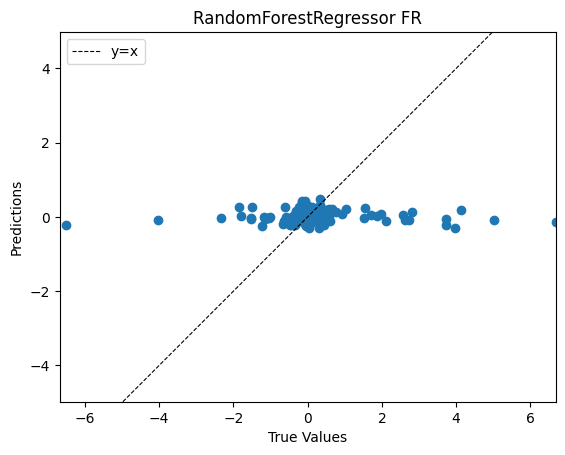

In [11]:
plot_scatter_predictions(y_test, y_pred, title=title)

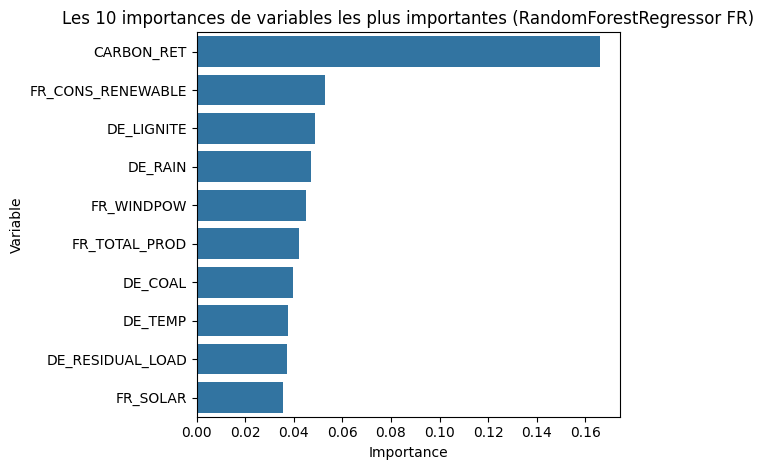

In [12]:
NUM_VAR = 10
test_results['fr']['importance'] = plot_top_coefficients_or_importances(rand_search, X, num_var=NUM_VAR, coef_type='feature_importances_', title=title)

## Allemagne

In [13]:
data_de = pd.read_csv('data/Data_DE.csv', index_col='ID')
data_de.shape

(596, 34)

In [14]:
X = data_de.drop('TARGET', axis=1)
y = data_de['TARGET']
title = 'RandomForestRegressor DE' 

In [15]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rand_search = RandomizedSearchCV(pipeline, param_grid, scoring=scoring, n_iter=n_iter, cv=cv, refit=refit, n_jobs=-1, verbose=1,random_state=42)
rand_search.fit(X_train, y_train)

y_pred = rand_search.predict(X_test)

test_results['de'] = get_test_results(rand_search, X_test, y_test, y_pred)
print_test_results(test_results['de'], refit, title=title)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

RandomForestRegressor DE
 Best estimator: 
  imputer : SimpleImputer(strategy='constant')
  scaler : RobustScaler()
  model : RandomForestRegressor(max_depth=3, min_samples_leaf=7, min_samples_split=10,
                      n_jobs=-1)
 Metrics:
  rmse: 1.05
  r2: 0.032
  r2 ajusté: -0.339
  spearman: 0.289
CPU times: total: 4.08 s
Wall time: 2min 25s


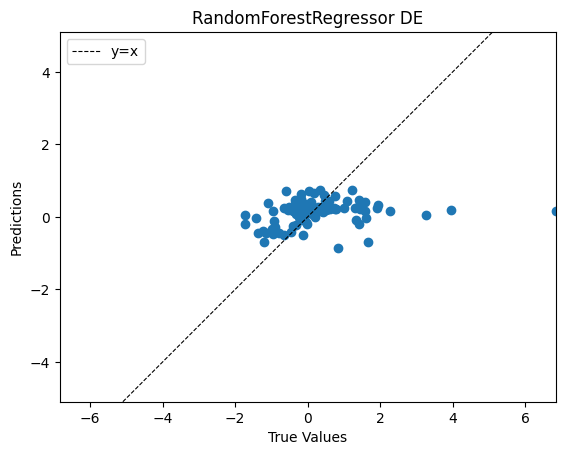

In [16]:
plot_scatter_predictions(y_test, y_pred, title=title)

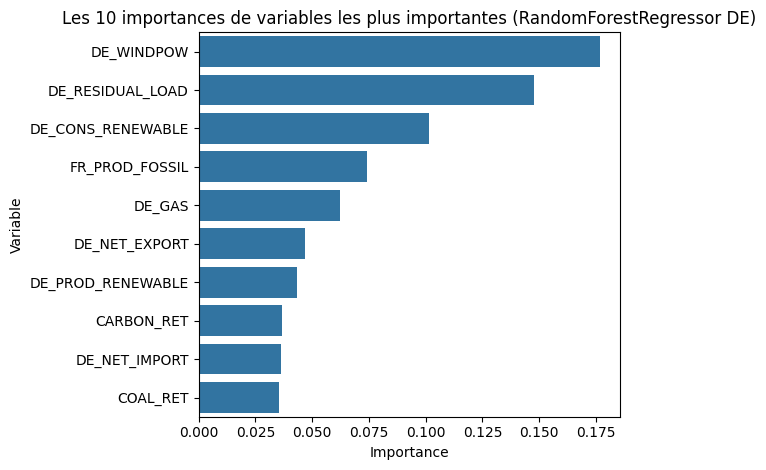

In [17]:
NUM_VAR = 10
test_results['de']['importance'] = plot_top_coefficients_or_importances(rand_search, X, num_var=NUM_VAR, coef_type='feature_importances_', title=title)

# Meilleur modele pour l'Allemange

Nous allons predire les variations des prix des futures pour les données non labelisés françaises

In [18]:
dataNew_x = pd.read_csv('data/DataNew_X.csv')
dataNew_x_de = dataNew_x[dataNew_x['COUNTRY'] == 'DE']
data_new_x_de = dataNew_x[dataNew_x['COUNTRY'] == 'DE'].drop(columns=['COUNTRY', 'DAY_ID', 'ID'])


data_new_x_de['FR_PROD_RENEWABLE'] = data_new_x_de['FR_SOLAR'] + data_new_x_de['FR_HYDRO'] + data_new_x_de['FR_WINDPOW'] + data_new_x_de['FR_NUCLEAR']
data_new_x_de['DE_PROD_RENEWABLE'] = data_new_x_de['DE_SOLAR'] + data_new_x_de['DE_HYDRO'] + data_new_x_de['DE_WINDPOW'] + data_new_x_de['DE_NUCLEAR']

data_new_x_de['DE_PROD_FOSIL'] = data_new_x_de['DE_COAL'] + data_new_x_de['DE_GAS'] + data_new_x_de['DE_LIGNITE']
data_new_x_de['FR_PROD_FOSSIL'] = data_new_x_de['FR_COAL'] + data_new_x_de['FR_GAS']

data_new_x_de['FR_CONS_RENEWABLE'] = data_new_x_de['FR_CONSUMPTION'] - data_new_x_de['FR_RESIDUAL_LOAD']
data_new_x_de['DE_CONS_RENEWABLE'] = data_new_x_de['DE_CONSUMPTION'] - data_new_x_de['DE_RESIDUAL_LOAD']

data_new_x_de['FR_TOTAL_PROD'] = data_new_x_de['FR_GAS'] + data_new_x_de['FR_COAL'] + data_new_x_de['FR_HYDRO'] + data_new_x_de['FR_NUCLEAR'] \
                            + data_new_x_de['FR_SOLAR'] + data_new_x_de['FR_WINDPOW']

data_new_x_de['DE_TOTAL_PROD'] = data_new_x_de['DE_GAS'] + data_new_x_de['DE_COAL'] + data_new_x_de['DE_HYDRO'] + data_new_x_de['DE_NUCLEAR'] \

data_new_x_de = data_new_x_de.drop(columns=['FR_CONSUMPTION','DE_WIND','DE_SOLAR','FR_GAS','DE_CONSUMPTION','FR_COAL','DE_NUCLEAR'])

dataNew_y_de = rand_search.predict(data_new_x_de)

df_dataNew_y_de = pd.DataFrame({'ID': dataNew_x_de['ID'], 'TARGET': dataNew_y_de})

df_dataNew_y_de.to_csv('data/DataNew_y_DE.csv')

# Conclusion

In [19]:
markdown_table = get_comparison_table(test_results, title='RandomForestRegressor')
Markdown(markdown_table)

| RandomForestRegressor      | FR                                       | DE                                       |
|-------------|--------------------------------------------|--------------------------------------------|
| Imputer     | SimpleImputer(strategy='constant')   | SimpleImputer(strategy='constant')   |
| Scaler      | RobustScaler()    | RobustScaler()    |
| Model       | RandomForestRegressor(max_depth=4, min_samples_leaf=9, min_samples_split=10,            n_jobs=-1)                                 | RandomForestRegressor(max_depth=3, min_samples_leaf=7, min_samples_split=10,            n_jobs=-1)                                 |
| RMSE        | 1.432               | 1.05               |
| R2          | -0.028                 | 0.032                 |
| R2 ajusté   | -0.361          | -0.339          |
| Spearman    | 0.048           | 0.289           |

In [20]:
# store results 
# pickle fait partie de la bibliotheque standard python (built-in)
import pickle

with open('results/RandomForestRegressor.pkl', 'wb') as f:
    pickle.dump(test_results, f)